In [1]:
import  pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import dtale
import matplotlib
%matplotlib inline
sns.set(font_scale=0.5)
plt.rcParams['figure.dpi'] = 150

## Load and prepare dataset

In [2]:
df = pd.read_csv("D:/triage/data/triage_recoding.csv")#(‪"D:\triage\data\data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205487 entries, 0 to 205486
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  205487 non-null  int64  
 1   Age         205487 non-null  int64  
 2   Kjonn       205480 non-null  object 
 3   Shift       196066 non-null  object 
 4   DOW         205487 non-null  object 
 5   EDLOS       205359 non-null  float64
 6   Hour_in     205487 non-null  int64  
 7   mrt         205487 non-null  int64  
 8   DischICU    205487 non-null  int64  
 9   Htriage     205487 non-null  int64  
 10  Triagestm   205487 non-null  int64  
dtypes: float64(1), int64(7), object(3)
memory usage: 17.2+ MB


In [4]:
df.drop(labels='Unnamed: 0',axis=1,inplace=True)

In [5]:
df.head()

,Age,Kjonn,Shift,DOW,EDLOS,Hour_in,mrt,DischICU,Htriage,Triagestm
0,54,Mann,NaN,Helg,85.0,16,0,0,4,1
1,9,Kvinne,Kveld,Man-fre,76.0,19,0,0,4,1
2,0,Mann,Dag,Man-fre,64.0,13,0,0,4,1
3,20,Mann,NaN,Helg,128.0,20,0,0,3,1
4,38,Mann,NaN,Helg,73.0,4,0,0,3,1


#### Distribution of triage scoring per stm version

In [6]:
df.Triagestm.value_counts(dropna=False)

2    85867
3    54279
1    43453
0    21888
Name: Triagestm, dtype: int64

<AxesSubplot:xlabel='Triagestm,Htriage'>

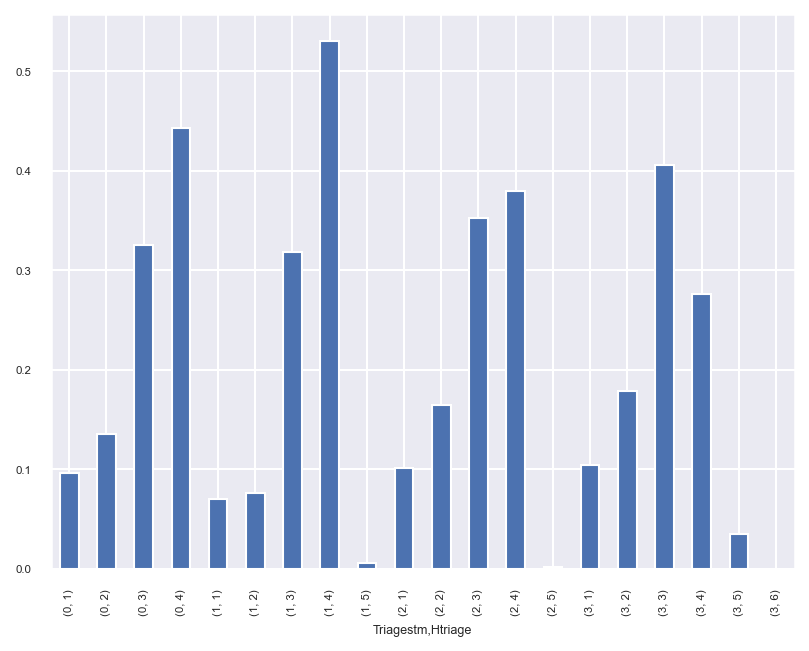

In [7]:
df.groupby('Triagestm').Htriage.value_counts(normalize=True).sort_index().plot(kind='bar')

#### Correlation matrix

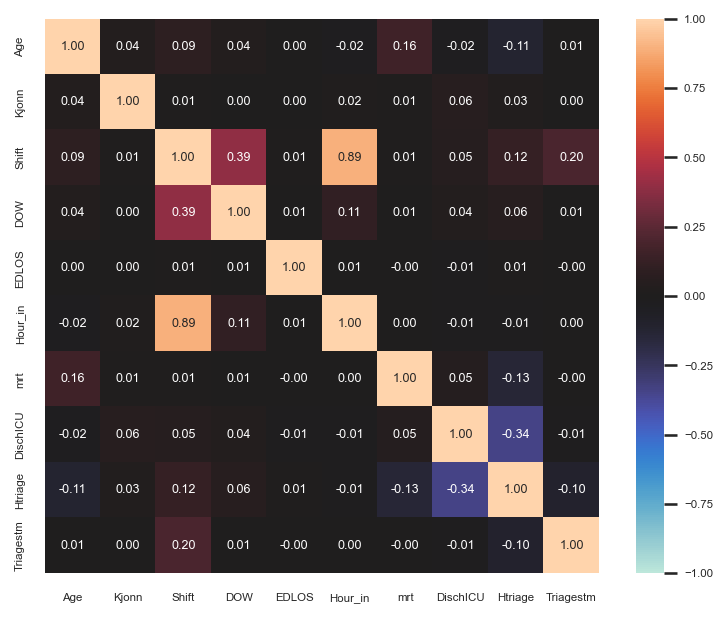

{'corr':                 Age     Kjonn     Shift       DOW     EDLOS   Hour_in  \
 Age        1.000000  0.035925  0.087762  0.036019  0.002533 -0.019667   
 Kjonn      0.035925  1.000000  0.012750  0.002270  0.001773  0.022343   
 Shift      0.087762  0.012750  1.000000  0.394238  0.011466  0.893135   
 DOW        0.036019  0.002270  0.394238  1.000000  0.007193  0.105287   
 EDLOS      0.002533  0.001773  0.011466  0.007193  1.000000  0.006701   
 Hour_in   -0.019667  0.022343  0.893135  0.105287  0.006701  1.000000   
 mrt        0.164033  0.009530  0.009197  0.005970 -0.001989  0.002701   
 DischICU  -0.017280  0.056392  0.053186  0.036548 -0.011315 -0.013458   
 Htriage   -0.114842  0.029309  0.121525  0.061904  0.012163 -0.008819   
 Triagestm  0.005710  0.003477  0.196977  0.005783 -0.002885  0.004304   
 
                 mrt  DischICU   Htriage  Triagestm  
 Age        0.164033 -0.017280 -0.114842   0.005710  
 Kjonn      0.009530  0.056392  0.029309   0.003477  
 Shift      0.

In [9]:
from dython.nominal import associations
associations(df)

## Build classification model

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205487 entries, 0 to 205486
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Age        205487 non-null  int64  
 1   Kjonn      205480 non-null  object 
 2   Shift      196066 non-null  object 
 3   DOW        205487 non-null  object 
 4   EDLOS      205359 non-null  float64
 5   Hour_in    205487 non-null  int64  
 6   mrt        205487 non-null  int64  
 7   DischICU   205487 non-null  int64  
 8   Htriage    205487 non-null  int64  
 9   Triagestm  205487 non-null  int64  
 10  Dead       205487 non-null  int32  
dtypes: float64(1), int32(1), int64(6), object(3)
memory usage: 16.5+ MB


#### Outcome variable - patient dead within 30 days

In [10]:
df['Dead'] = np.where(df.mrt>0,1,0)
df_m = df.drop(labels=['EDLOS','Hour_in','mrt'],axis=1)

#### Define data and outcome for model

In [11]:

X = df_m.loc[:,]
y = df_m.loc[:,'Dead']

In [12]:
y.value_counts(normalize=False)

0    198518
1      6969
Name: Dead, dtype: int64

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205487 entries, 0 to 205486
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Age        205487 non-null  int64 
 1   Kjonn      205480 non-null  object
 2   Shift      196066 non-null  object
 3   DOW        205487 non-null  object
 4   DischICU   205487 non-null  int64 
 5   Htriage    205487 non-null  int64 
 6   Triagestm  205487 non-null  int64 
 7   Dead       205487 non-null  int32 
dtypes: int32(1), int64(4), object(3)
memory usage: 11.8+ MB


#### Function for plotting ROC-curves based on cross-validation

In [14]:
def cv_roc(X,y,estimator,cv,groups=None):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    
    for train, test in cv.split(X,y,groups):
        probas_ = estimator.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:, 1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.1f)' % (i, roc_auc*100))

        i += 1
    plt.plot([0, 1], [0, 1], 'r--')

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)*3
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.1f $\pm$ %0.1f)' % (mean_auc*100, std_auc*100),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)*3
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 3 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

#### Setup pipeline

Here we do some simple preprocessing steps for numerical (imputing missing values) and categorical variables; -  in the latter we use ordinal encoding (mapping categories to numbers) as we will use a tree-algorithm. Can also switch to One-hot-encoding if needed for other models.

In [15]:
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
#from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate,cross_val_score,StratifiedKFold#,StratifiedGroupKFold
#from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
#from imblearn.under_sampling import RandomUnderSampler
from sklearn.cluster import KMeans
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve,auc,brier_score_loss

num_pipe = SimpleImputer(strategy="mean")#, add_indicator=True)
cat_pipe = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="missing"),
   # OneHotEncoder(handle_unknown='ignore')
    OrdinalEncoder()#handle_unknown="use_encoded_value", unknown_value=-1),
)

preprocessor = make_column_transformer(
    (num_pipe, selector(dtype_include=['int64','float64'])),
    (cat_pipe, selector(dtype_include=['object'])),
    n_jobs=2,
)
    

Use random forest classifier. Can test both with different scheme to handle the unbalanced dataset; undersampling the majority class or using class weights in tree-algorithm.

In [16]:


rf_clf = make_pipeline(
    preprocessor,
  # RandomUnderSampler(random_state=42),
    # xgb.XGBClassifier(use_label_encoder=False,eval_metric='logloss')
    RandomForestClassifier(random_state=42,class_weight="balanced")
   # BalancedRandomForestClassifier()
)


#### Build and evaluate using cross-validation

We do a stratifold 3-fold scheme, with shuffling of the data. 

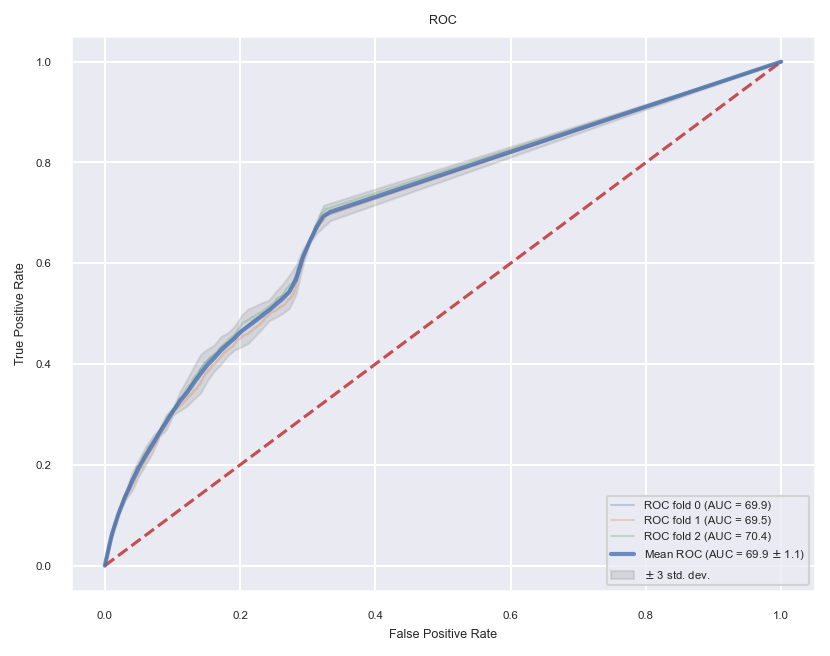

In [17]:
cv=StratifiedKFold(n_splits=3,shuffle=True)
cv_roc(X,y,rf_clf,cv)

#### Feature importance

<AxesSubplot:>

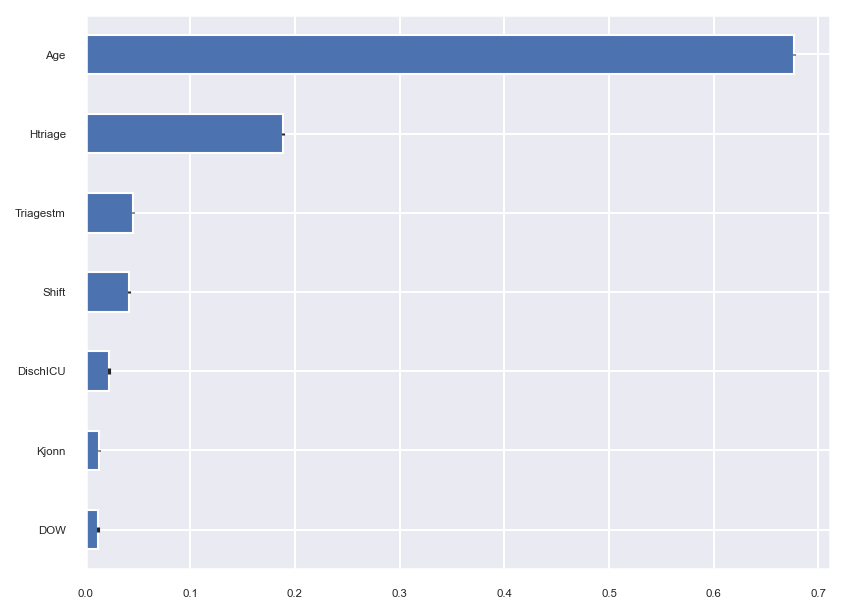

In [18]:
pl = rf_clf.fit(X,y)
forest = pl.steps[1][1]

cols = preprocessor.transformers_[0][2] + preprocessor.transformers_[1][2]

importance = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importance, index=cols)

fig, ax = plt.subplots()
forest_importances.sort_values().plot(kind='barh',yerr=std, ax=ax)

### Miscellaneous analyses and plots

In [168]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.33, random_state=42)

In [169]:
pl = rf_clf.fit(X_train,y_train)

In [170]:
y_pred = pl.predict(X_test)

In [171]:
cf_matrix = confusion_matrix(y_test, y_pred)
cf_matrix

array([[55894,  9572],
       [ 1436,   909]], dtype=int64)

<AxesSubplot:>

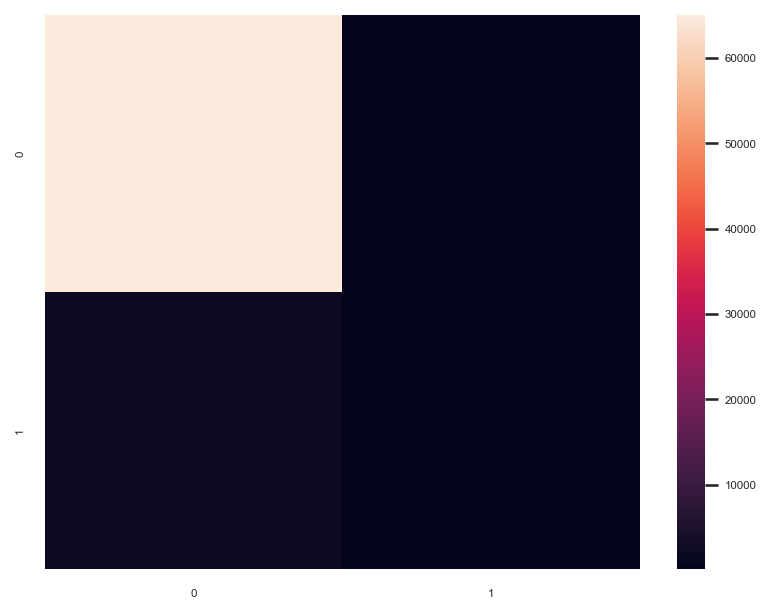

In [162]:
import seaborn as sns
sns.heatmap(cf_matrix, annot=True)

In [143]:
pd.cut(df.EDLOS,[0,20,40,80,100,120,np.inf])
#pd.cut(df.Age,[0,20,40,60,80,np.inf])

0          (80.0, 100.0]
1           (40.0, 80.0]
2           (40.0, 80.0]
3           (120.0, inf]
4           (40.0, 80.0]
               ...      
205482    (100.0, 120.0]
205483      (120.0, inf]
205484      (120.0, inf]
205485      (120.0, inf]
205486      (120.0, inf]
Name: EDLOS, Length: 205487, dtype: category
Categories (6, interval[float64]): [(0.0, 20.0] < (20.0, 40.0] < (40.0, 80.0] < (80.0, 100.0] < (100.0, 120.0] < (120.0, inf]]

In [114]:
#ax = df[df.Dead==0].Minutes_in.hist(density=True,alpha=0.5)
#df[df.Dead==1].Minutes_in.hist(density=True,ax =ax,alpha=0.5)

In [39]:
d = df.copy()
d.Dead = np.where(d.mrt==1,1,0)
d.groupby(['Triagestm','Dead']).Dead.count()

Triagestm  Dead
0          0       21784
           1         104
1          0       43180
           1         273
2          0       85434
           1         433
3          0       54017
           1         262
Name: Dead, dtype: int64

<AxesSubplot:xlabel='Htriage'>

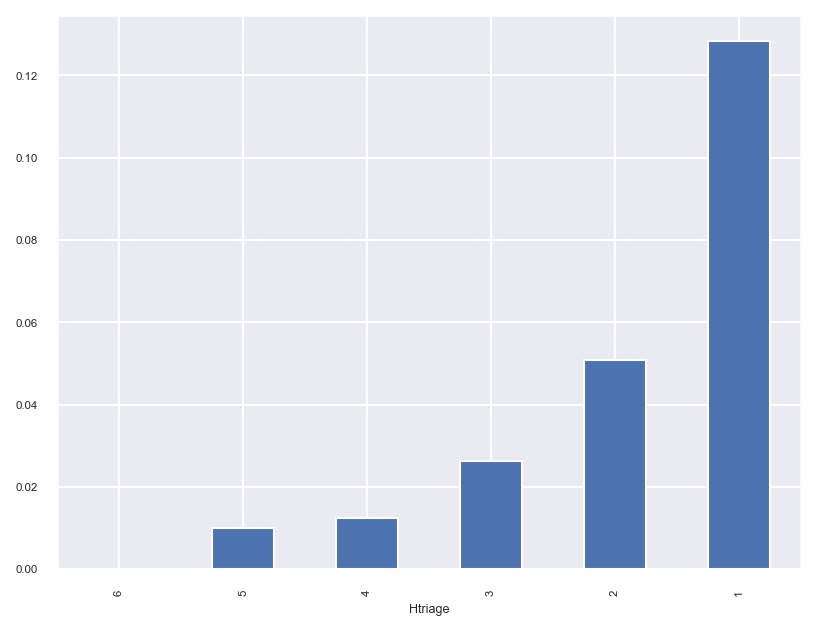

In [30]:
d = pd.crosstab(df.Htriage,df.Dead).reset_index().rename(columns={0:'Alive',1:'Dead'}).\
                assign(Total = lambda x: x['Dead']+x['Alive']).assign(Andel = lambda x: x['Dead']/x['Total']).sort_values(by='Andel',ascending=False)
d.set_index(d.columns[0]).Andel.sort_values().plot(kind='bar')